<a href="https://colab.research.google.com/github/FowadIjaz/Portfolio/blob/main/Stock_Price_Prediction_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Project Overview**

*This project was completed by Fowad Ijaz, Bishal Podder, Akshay Hegde, Prathamesh Sinha, and Sourav Dasgupta for F743: Big Data in Finance taught by A. Mahmood at the DeGroote School of Business in Fall 2020.*

The purpose of this project was to predict stock prices 60 days in the future for all stocks in the S$P 500 Index.


### **Methods**

The 5-year Stock Price data was taken from the following [Kaggle Dataset](https://www.kaggle.com/camnugent/sandp500). It contained stock prices for all S&P 500 stocks from Feb 2013 to Feb 2018. In total, the dataset had close to 500,000 rows and 6 columns.

The machine learning algorithms chosen for this particular assignment were RandomForest, ADAboost, and GradientBoost Regressors. Of the 3, the ML model that was most successful was GradientBoost Regressor, with a score of over 98%.


### **Data Cleaning**

In [ ]:
# Importing relevant libraries
import numpy as np
import pandas as pd
#ScikitLearn: 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#Matplotlib and Seaborn:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns

In [ ]:
# Reading DataFrame from CSV
df = pd.read_csv(r'/content/drive/MyDrive/MBA/MBA Term 7 - Fall 2020/F743/Final Project Raw Data/Stock_Data.csv', header = 0, sep = ',')
df

,a_date,open,high,low,close,volume,Name,52 week high,% Over/Under 52WKH,20 Day MA,% Over Under 20DMA,50 Day MA,% Over Under 50DMA,100 Day MA,% Over Under 100DMA,200 Day MA,% Over Under 200DMA,Average Gain/Loss,Average Gains2,Av Losses2,RSI V2,S&P500_open,S&P500_high,S&P500_low,S&P500_close,S&P500_52 week high,S&P500_% Over/Under 52WKH,S&P500_20 Day MA,S&P500_% Over Under 20DMA,S&P500_50 Day MA,S&P500_% Over Under 50DMA,S&P500_100 Day MA,S&P500_% Over Under 100DMA,S&P500_200 Day MA,S&P500_% Over Under 200DMA,S&P500_Average Gain/Loss,S&P500_Average Gains2,S&P500_Av Losses2,S&P500_RSI V2,Alpha,Signal
0,2014-02-20,34.43,35.6694,34.43,35.66,9289448.0,AAL,35.67,-0.000280,33.78775,0.052503,29.7528,0.165653,25.9190,0.273163,21.73880,0.390387,0.030934,0.008443,-0.004493,65.269321,1829.24,1842.79,1824.58,1839.78,1848.38,-0.004653,1798.9785,0.022680,1813.7914,0.014328,1782.7328,0.032000,1720.68075,0.069216,0.006031,0.004559,-0.002723,62.607123,++++,Bullish
1,2014-02-21,35.78,36.4500,35.75,36.17,7821334.0,AAL,36.17,0.000000,34.02875,0.059200,29.9842,0.171020,26.0899,0.278687,21.83475,0.396330,0.014302,0.009465,-0.003964,70.478968,1841.07,1846.13,1835.60,1836.25,1848.38,-0.006563,1799.3680,0.020497,1814.3490,0.012071,1784.1778,0.029186,1721.73220,0.066513,-0.001919,0.004559,-0.002398,65.529727,++++,Bullish
2,2014-02-24,36.20,36.6600,36.02,36.65,7022370.0,AAL,36.65,0.000000,34.34125,0.062995,30.2196,0.175454,26.2668,0.283307,21.93130,0.401602,0.013271,0.009540,-0.003964,70.642936,1836.78,1858.71,1836.78,1847.61,1848.38,-0.000417,1802.2340,0.025178,1815.2488,0.017827,1785.8384,0.034590,1722.80680,0.072442,0.006187,0.005001,-0.000767,86.698898,++++,Bullish
3,2014-02-25,36.63,37.1500,36.51,37.00,8991389.0,AAL,37.00,0.000000,34.68225,0.062642,30.4398,0.177303,26.4399,0.285408,22.02940,0.404611,0.009550,0.010033,-0.003964,71.676575,1847.66,1852.91,1840.19,1845.12,1848.38,-0.001764,1805.4120,0.021994,1816.5068,0.015752,1787.3396,0.032328,1723.89905,0.070318,-0.001348,0.004455,-0.000863,83.764614,++++,Bullish
4,2014-02-26,37.12,37.2800,36.58,36.75,10516864.0,AAL,37.00,-0.006803,34.92175,0.049748,30.6658,0.165556,26.6090,0.275946,22.12435,0.397977,-0.006757,0.010033,-0.003923,71.891334,1845.79,1852.65,1840.66,1845.16,1848.38,-0.001742,1808.0450,0.020528,1817.9000,0.014995,1788.8525,0.031477,1724.95635,0.069685,0.000022,0.004456,-0.000719,86.114469,++++,Bullish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495658,2018-02-01,2816.45,2835.9600,2812.70,2821.98,NaN,S&P 500,2872.87,-0.017714,2799.94950,0.007868,2711.5490,0.040726,2629.4468,0.073222,2530.28750,0.115280,-0.000648,0.003123,-0.001713,64.581306,2816.45,2835.96,2812.70,2821.98,2872.87,-0.017714,2799.9495,0.007868,2711.5490,0.040726,2629.4468,0.073222,2530.28750,0.115280,-0.000648,0.003123,-0.001713,64.581306,++++,Bullish
495659,2018-02-02,2808.92,2808.9200,2759.97,2762.13,NaN,S&P 500,2872.87,-0.038547,2801.85650,-0.014179,2715.1488,0.017303,2632.1870,0.049367,2532.40730,0.090713,-0.021209,0.002641,-0.003228,45.001319,2808.92,2808.92,2759.97,2762.13,2872.87,-0.038547,2801.8565,-0.014179,2715.1488,0.017303,2632.1870,0.049367,2532.40730,0.090713,-0.021209,0.002641,-0.003228,45.001319,++++,Bullish
495660,2018-02-05,2741.06,2763.3900,2638.17,2648.94,NaN,S&P 500,2872.87,-0.077946,2797.14600,-0.052985,2716.1470,-0.024744,2633.7116,0.005782,2533.87280,0.045412,-0.040979,0.002641,-0.005903,30.910398,2741.06,2763.39,2638.17,2648.94,2872.87,-0.077946,2797.1460,-0.052985,2716.1470,-0.024744,2633.7116,0.005782,2533.87280,0.045412,-0.040979,0.002641,-0.005903,30.910398,++++,Bullish
495661,2018-02-06,2614.78,2701.0400,2593.07,2695.14,NaN,S&P 500,2872.87,-0.061865,2794.51750,-0.035562,2718.1082,-0.008450,2635.6793,0.022560,2535.60505,0.062918,0.017441,0.003214,-0.005903,35.254614,2614.78,2701.04,2593.07,2695.14,2872.87,-0.061865,2794.5175,-0.035562,2718.1082,-0.008450,2635.6793,0.022560,25

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


     \ 56.2MB 80.7MB/s
     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 604kB 21.1MB/s 
     |████████████████████████████████| 3.1MB 12.6MB/s 
     |████████████████████████████████| 71kB 7.0MB/s 
     |████████████████████████████████| 296kB 41.5MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.10.0-py2.py3-none-any.whl size=232425 sha256=e172415316978b9a053fce8f8b829248f6791f25e71edc78bd46ace141f2e1f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-hr1x0uic/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=080fc84f1ab5f81169f10f41dcb48d0628db5128cce15caf1de0e56aeddcdcfa
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built pandas-profiling htmlmin
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully un

NameError: ignored

In [ ]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title="Stock Dataset", html={'style': {'full_width': True}})

Summarize dataset:   0%|          | 0/55 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
## TRANSFORMATION OF THE DATAFRAME FOR DATA PREPARATION
# Removing rows containing S&P 500 data from the bottom of the table (has been placed alongside every row to allow for comparison with every stock)
df = df[df.Name != "S&P 500"]

# Changing name of Date column from a_date to Date for ease of use
df = df.rename(columns={'a_date':'Date'})
#df

# Changing SignalVal variable to categorical
df['SignalVal'] = df['Signal'].astype('category').cat.codes
#df

# Removing closing stock prce
df['ClosingStockPrice'] = df['close']
df=df.drop(['close','Alpha','Signal'],axis=1)
#df

# Sorting Dataframe by name and date
df = df.sort_values(by=['Date','Name'], ascending= True)
#df

# Turning Stock name into an integer value between 0 and 504
df['Name'] = df['Name'].astype('category').cat.codes
#df

# Resetting the index to be in ascending order
df= df.reset_index(drop=True)
#df

# Creating a dataframe with just the date column
df2= df['Date']
df2

# Unused, for making Date into the index
#df.index = df.Date
#df.drop('Date',axis=1, inplace=True)

0         2014-02-20
1         2014-02-20
2         2014-02-20
3         2014-02-20
4         2014-02-20
             ...    
494658    2018-02-07
494659    2018-02-07
494660    2018-02-07
494661    2018-02-07
494662    2018-02-07
Name: Date, Length: 494663, dtype: object

In [ ]:
# Creating a list of 505 lists for each of the stocks. Purpose is to remove lists with less than 1000 entries (a few stocks were added or removed from the index).
# This was done to standardize the number of records for each stock, so that the final dataset could have a regularized shape 

df_list = []
for i in range(0,505):
  df_list.append(df[df.Name == i])

# The following stock for example did not have 1000 rows
len(df_list[49])

1000

In [ ]:
# Removing stocks that had less than 1000 rows of data from the LIST
list_drop = []
for i in range(0,505):
  if len(df_list[i])<1000:
    list_drop.append(i)
list_drop 
# len(list_drop)

[48,
 67,
 68,
 93,
 120,
 136,
 151,
 152,
 166,
 172,
 198,
 206,
 226,
 231,
 232,
 241,
 246,
 267,
 328,
 350,
 387,
 389,
 430,
 453,
 484,
 488]

In [ ]:
# Removing stocks that had less than 1000 rows of data from the DATAFRAME
for i in list_drop:
  df = df[df.Name != i]

In [ ]:
# Filling NA a values with zeros 
df =  df.fillna(0)
df.isnull().sum()

# Calling the dataframe after all the tranformations have been completed
df

,Date,open,high,low,volume,Name,52 week high,% Over/Under 52WKH,20 Day MA,% Over Under 20DMA,50 Day MA,% Over Under 50DMA,100 Day MA,% Over Under 100DMA,200 Day MA,% Over Under 200DMA,Average Gain/Loss,Average Gains2,Av Losses2,RSI V2,S&P500_open,S&P500_high,S&P500_low,S&P500_close,S&P500_52 week high,S&P500_% Over/Under 52WKH,S&P500_20 Day MA,S&P500_% Over Under 20DMA,S&P500_50 Day MA,S&P500_% Over Under 50DMA,S&P500_100 Day MA,S&P500_% Over Under 100DMA,S&P500_200 Day MA,S&P500_% Over Under 200DMA,S&P500_Average Gain/Loss,S&P500_Average Gains2,S&P500_Av Losses2,S&P500_RSI V2,SignalVal,ClosingStockPrice
0,2014-02-20,56.1400,57.5350,56.0450,4629755.0,0,60.9300,-0.063536,58.02450,-0.012821,57.779800,-0.008549,54.891300,0.041869,50.454550,0.119313,0.024133,0.008602,-0.010923,44.057448,1829.24,1842.79,1824.58,1839.78,1848.38,-0.004653,1798.9785,0.022680,1813.7914,0.014328,1782.7328,0.032000,1720.68075,0.069216,0.006031,0.004559,-0.002723,62.607123,0,57.2900
1,2014-02-20,34.4300,35.6694,34.4300,9289448.0,1,35.6700,-0.000280,33.78775,0.052503,29.752800,0.165653,25.919000,0.273163,21.738800,0.390387,0.030934,0.008443,-0.004493,65.269321,1829.24,1842.79,1824.58,1839.78,1848.38,-0.004653,1798.9785,0.022680,1813.7914,0.014328,1782.7328,0.032000,1720.68075,0.069216,0.006031,0.004559,-0.002723,62.607123,1,35.6600
2,2014-02-20,125.9800,128.0600,125.7700,882740.0,2,127.5600,0.000000,119.82800,0.060615,115.019400,0.098311,105.228700,0.175065,93.806650,0.264608,0.012863,0.013025,-0.005118,71.789496,1829.24,1842.79,1824.58,1839.78,1848.38,-0.004653,1798.9785,0.022680,1813.7914,0.014328,1782.7328,0.032000,1720.68075,0.069216,0.006031,0.004559,-0.002723,62.607123,1,127.5600
3,2014-02-20,76.1414,76.7142,75.5714,76529103.0,3,81.4413,-0.073312,75.13765,0.009764,77.393062,-0.019960,75.655671,0.002937,70.177389,0.075135,-0.011575,0.006434,-0.002029,76.027627,1829.24,1842.79,1824.58,1839.78,1848.38,-0.004653,1798.9785,0.022680,1813.7914,0.014328,1782.7328,0.032000,1720.68075,0.069216,0.006031,0.004559,-0.002723,62.607123,0,75.8785
4,2014-02-20,51.1900,52.1100,50.7300,6078933.0,4,54.3200,-0.047435,49.07700,0.053664,50.659600,0.023147,49.239200,0.050536,46.733500,0.098853,0.013088,0.008915,-0.003727,70.518376,1829.24,1842.79,1824.58,1839.78,1848.38,-0.004653,1798.9785,0.022680,1813.7914,0.014328,1782.7328,0.032000,1720.68075,0.069216,0.006031,0.004559,-0.002723,62.607123,1,51.8600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494658,2018-02-07,71.2700,72.8600,71.1200,1748941.0,500,75.6600,-0.053907,72.22550,-0.006066,69.811800,0.027555,67.414450,0.060949,61.686075,0.140743,0.006449,0.007133,-0.006301,53.096000,2690.95,2727.67,2681.33,2681.66,2872.87,-0.066557,2791.0360,-0.039188,2719.6930,-0.013984,2637.5397,0.016728,2537.14260,0.056961,-0.005002,0.003214,-0.006145,34.343784,1,71.7900
494659,2018-02-07,80.0700,81.9400,80.0000,3561068.0,501,86.4800,-0.079246,83.61100,-0.043442,82.888800,-0.034429,79.730900,0.004981,76.546600,0.044720,-0.005585,0.004063,-0.006569,38.212517,2690.95,2727.67,2681.33,2681.66,2872.87,-0.066557,2791.0360,-0.039188,2719.6930,-0.013984,2637.5397,0.016728,2537.14260,0.056961,-0.005002,0.003214,-0.006145,34.343784,0,80.1300
494660,2018-02-07,121.6500,123.5200,120.7400,1145267.0,502,132.6100,-0.097947,124.20750,-0.028378,120.670200,0.000909,118.452500,0.019271,119.748000,0.008544,-0.012428,0.005400,-0.006147,46.766489,2690.95,2727.67,2681.33,2681.66,2872.87,-0.066557,2791.0360,-0.039188,2719.6930,-0.013984,2637.5397,0.016728,2537.14260,0.056961,-0.005002,0.003214,-0.006145,34.343784,1,120.7800
494661,2018-02-07,52.2300,54.3150,52.2200,6427280.0,503,54.9800,-0.017771,53.50650,0.009506,51.634200,0.044165,48.920000,0.094409,45.887100,0.150553,0.028561,0.007964,-0.006243,56.057889,2690.95,2727.67,2681.33,2681.66,2872.87,-0.066557,2791.0360,-0.039188,2719.6930,-0.013984,2637.5397,0.016728,2537.14260,0.056961,-0.005002,0.

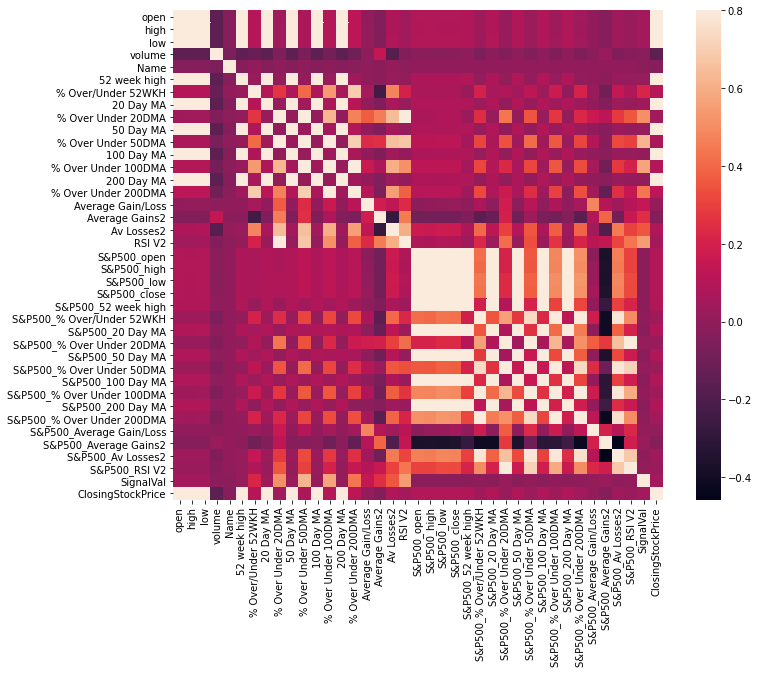

In [ ]:
# Checking collinearity of variables by creating a correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

### **Creating X-Y split**

All variables apart from Closing Stock Price were placed in the set of X (independent) variables. Closing Stock Price was the Y (dependent) variable.

In [ ]:
# Creating X and Y split, and offsetting data by 479*60. 479 is the number of stocks remaining on the list, while 60 is the number of days to be offset by 
X = df.values[:(len(df)-(479*60)),0:41]
Y = df.values[60*479:,-1]

In [ ]:
# Printing the shapes to ensure they are the appropriate size
print(X.shape,
      Y.shape)

(450260, 40) (450260,)


### **Creating Train-Test sets.**

For the purposes of creating a more robust model, we opted not to split the dataset into a chronologically earlier training set followed by a chronologically later test set. Instead, the training set was randomly chosen from records within the span of 2014 to 2018, and so was the test set. 

The train-test split was done 75-25. 

In [ ]:
# Creating Train-Test split from X and Y data, using randomized rows from entire dataset instead of chronological
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size = 0.25, random_state = 100)


# traintest split instead of chronological, might not get as good a predictive model (do both ways start with train-test split)
# Y is the next 12 months data (regardless of train- test split)
# Might try to predict 1 month forward

In [ ]:
# Printing the shapes to ensure they are the appropriate size

print(X_train.shape,
      Y_train.shape,
      
      X_test.shape,
      Y_test.shape)

(337695, 40) (337695,) (112565, 40) (112565,)


In [ ]:

X_test_date = X_test[:,0]
X_test_date

array(['2017-05-02', '2016-12-07', '2014-08-20', ..., '2017-03-15',
       '2015-07-23', '2015-02-02'], dtype=object)

In [ ]:
X_test = X_test[:,1:]
X_test

array([[249.9, 251.02, 248.76, ..., 63.93915415, 1, 250.84],
       [81.25, 83.4, 80.6, ..., 75.75602724, 1, 83.15],
       [162.19, 163.26, 161.68, ..., 71.03595853, 0, 162.78],
       ...,
       [121.74, 122.73, 121.02, ..., 59.24559951, 0, 122.12],
       [558.19, 559.78, 553.14, ..., 57.85643971, 1, 556.61],
       [33.24, 33.81, 32.88, ..., 48.79504779999999, 0, 33.77]],
      dtype=object)

In [ ]:
X_train = X_train[:,1:]
X_train

array([[77.33, 77.88, 76.65, ..., 67.48817556, 1, 76.78],
       [67.58, 68.65, 67.32, ..., 41.25669323, 1, 68.6],
       [109.78, 110.44, 108.93, ..., 55.86416212, 0, 109.31],
       ...,
       [35.8, 36.685, 35.74, ..., 46.89373178, 1, 36.6],
       [107.48, 107.75, 106.0, ..., 22.92593789, 1, 107.12],
       [36.63, 36.7, 36.01, ..., 56.65291473, 0, 36.19]], dtype=object)

In [ ]:
print(X_train.shape,
      Y_train.shape,
      
      X_test.shape,
      Y_test.shape)

(337695, 39) (337695,) (112565, 39) (112565,)


### **RandomForest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RF_Model= RandomForestRegressor(max_depth=3, random_state=0)
RF_Model.fit(X_train, Y_train)
RF_Model.score(X_train, Y_train)

0.9540581916489024

In [ ]:
Y_test_RF = RF_Model.predict(X_test)
print ("RF accuracy is ", RF_Model.score(X_test,Y_test)*100)

RF accuracy is  95.28908183499983


In [ ]:
Y_test_RF

array([288.70656733,  85.99752344, 155.08011625, ..., 146.05468683,
       578.62109233,  40.53820719])

In [ ]:
sample = X_test[100:105,:]
sampley = Y_test[100:105]


In [ ]:
Y_predict1 = RF_Model.predict(sample)
# prof's suggested method of checking how good the results are
RF_Model.score(sample,sampley)*100

99.11061083594491

In [ ]:
Y_predict1

array([ 40.53820719, 155.08011625,  40.53820719,  85.99752344,
        40.53820719])

In [ ]:
pd.DataFrame(data=[Y_test,Y_test_RF])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,112525,112526,112527,112528,112529,112530,112531,112532,112533,112534,112535,112536,112537,112538,112539,112540,112541,112542,112543,112544,112545,112546,112547,112548,112549,112550,112551,112552,112553,112554,112555,112556,112557,112558,112559,112560,112561,112562,112563,112564
0,282.490000,94.540000,170.780000,25.150000,95.400000,37.480000,61.650000,54.666700,32.735000,26.200000,121.090000,106.570000,78.830000,67.960000,36.800000,69.810000,65.830000,290.890000,79.960000,68.340000,40.520000,154.010000,42.940000,61.220000,71.550000,63.390000,191.550000,55.780000,103.660000,14.190000,81.220000,15.410000,47.510000,96.080000,59.590000,156.680000,82.870000,59.470000,217.960000,77.660000,...,71.170000,154.920000,125.500000,42.830000,82.260000,147.070000,130.310000,198.170000,45.000000,72.910000,46.130000,358.980000,190.360000,132.190000,191.200000,184.640000,45.130000,62.385000,114.000000,105.600000,85.590000,63.640000,67.850000,72.570000,44.300000,83.570000,44.420000,57.320000,447.900000,34.870000,47.280000,39.650000,652.480000,54.350000,137.460000,52.200000,16.260000,105.380000,514.590000,34.620000
1,288.706567,85.997523,155.080116,40.538207,85.997523,40.538207,40.538207,40.538207,40.538207,40.538207,87.276923,85.997523,85.997523,85.997523,40.538207,52.013237,80.236454,288.706567,85.997523,40.538207,77.492105,155.080116,40.538207,40.538207,85.997523,85.997523,155.080116,40.538207,85.997523,40.538207,85.997523,40.538207,40.538207,85.997523,40.538207,155.080116,85.997523,85.997523,217.768244,85.997523,...,85.508969,155.080116,121.681742,40.538207,85.997523,155.080116,146.054687,155.080116,40.538207,85.997523,40.538207,288.706567,155.080116,85.997523,155.080116,155.080116,40.538207,85.997523,85.997523,100.958269,85.997523,85.997523,59.704457,85.508969,40.538207,85.997523,40.538207,40.538207,422.921975,40.538207,80.236454,40.538207,578.621092,80.236454,85.997523,40.538207,40.538207,146.054687,578.621092,40.538207


### **Graphing RandomForest Regressor**

In [ ]:
# merging the arrays for graphing purposes
Chart1 = pd.DataFrame(data = X_test_date, columns=["Date"])
Chart2 = pd.DataFrame(data= Y_test, columns= ["Y_test"])
Chart3 = pd.DataFrame(data= Y_test_RF, columns= ["Y_test_RF"])
Chart4 = pd.DataFrame(data = X_test[:,4], columns=["Name"])

Chart = pd.concat([Chart1, Chart4, Chart2, Chart3], axis = 1)

Chart2 = Chart.sort_values(by=['Date', "Name"], ascending= True)
Chart2["Date"] = pd.to_datetime(Chart2.Date,format='%Y-%m-%d')
Chart2.index = Chart2["Date"]

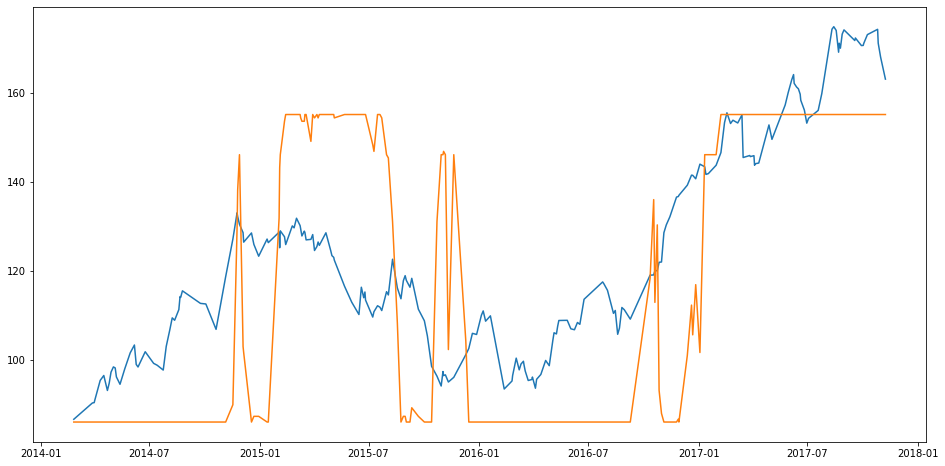

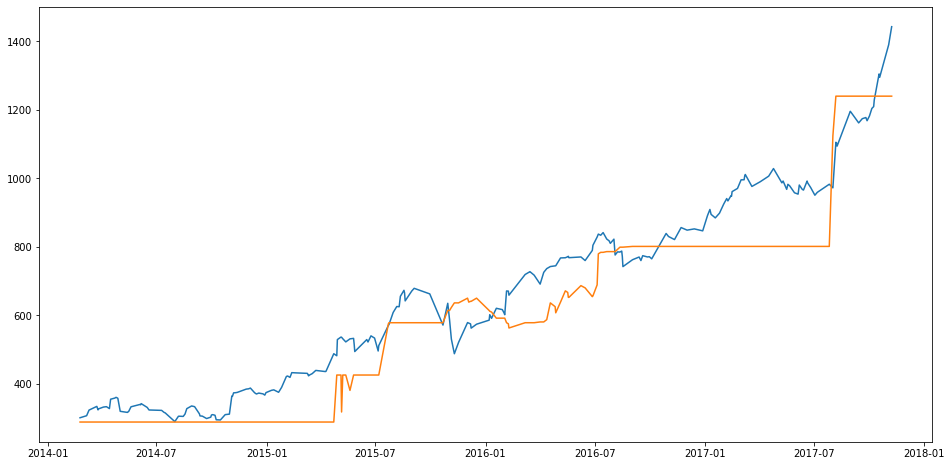

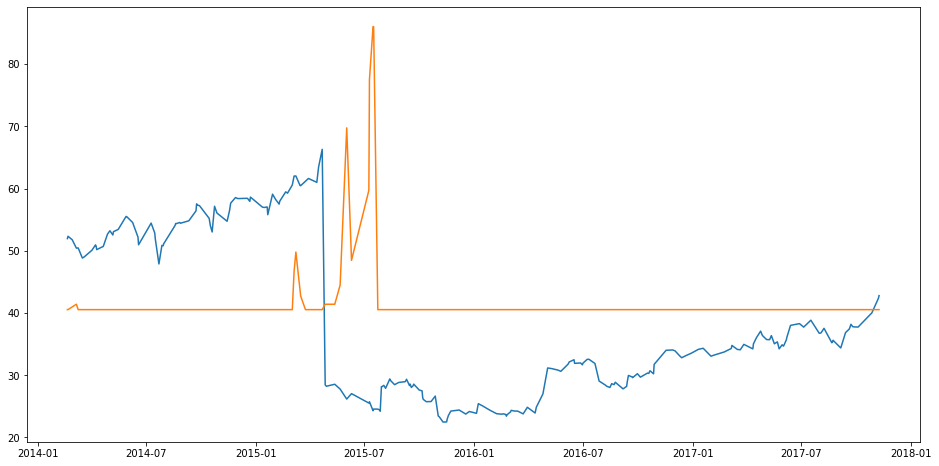

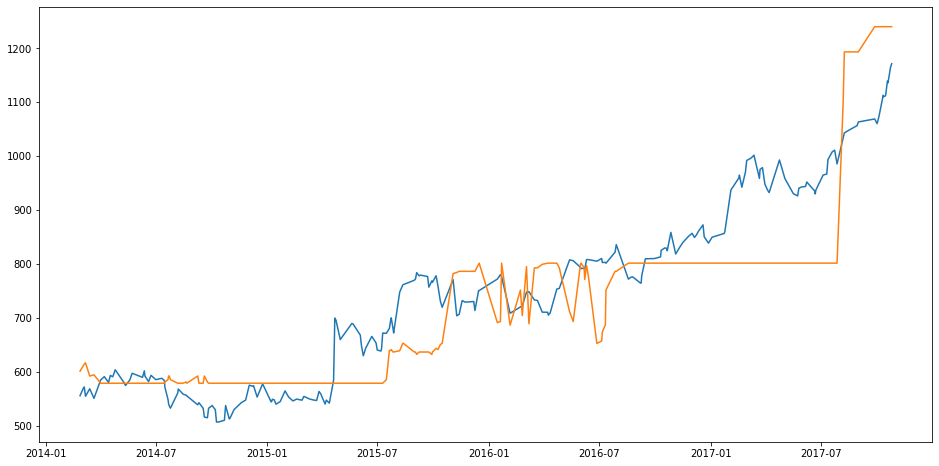

In [ ]:
rcParams['figure.figsize'] = 20,10

#plots
for i in [3, 38, 154, 207]:
  Chart3 = Chart2[Chart2.Name == i]
  plt.figure(figsize=(16,8))
  plt.plot(Chart3['Y_test'], label='Close Price history')
  plt.plot(Chart3['Y_test_RF'], label='Close Price history')
# 3, 38, 154, 207 Corresponds to the 4 sample stock names: AAPL, AMZN, EBAY, GOOGL

### **AdaBoostRegressor**

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import accuracy_score

clf_ADA = AdaBoostRegressor(n_estimators=50, learning_rate=1, random_state=0)
clf_ADA.fit(X_train, Y_train)
clf_ADA.score(X_train, Y_train)

In [ ]:
Y_test_ADA = clf_ADA.predict(X_test)
Y_test_ADA

array([242.57535652,  83.46893932, 149.55058524, ...,  87.9514142 ,
       545.15774581,  69.20318958])

In [ ]:
print ("ADA boost accuracy is ", clf_ADA.score(X_test,Y_test)*100)

ADA boost accuracy is  91.94564714612808


In [ ]:
pd.DataFrame(data=[Y_test,Y_test_ADA])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,112525,112526,112527,112528,112529,112530,112531,112532,112533,112534,112535,112536,112537,112538,112539,112540,112541,112542,112543,112544,112545,112546,112547,112548,112549,112550,112551,112552,112553,112554,112555,112556,112557,112558,112559,112560,112561,112562,112563,112564
0,282.490000,94.540000,170.780000,25.15000,95.400000,37.48000,61.65000,54.66670,32.73500,26.20000,121.09000,106.57000,78.830000,67.960000,36.80000,69.810000,65.830000,290.890000,79.96000,68.34000,40.520000,154.010000,42.94000,61.22000,71.550000,63.390000,191.55000,55.78000,103.660000,14.19000,81.22000,15.41000,47.51000,96.080000,59.59000,156.680000,82.87000,59.470000,217.960000,77.66000,...,71.170000,154.920000,125.500000,42.83000,82.26000,147.070000,130.310000,198.17000,45.00000,72.910000,46.13000,358.980000,190.360000,132.19000,191.20000,184.640000,45.13000,62.385000,114.00000,105.600000,85.590000,63.640000,67.850000,72.570000,44.30000,83.57000,44.42000,57.32000,447.900000,34.87000,47.280000,39.65000,652.480000,54.350000,137.46000,52.20000,16.26000,105.380000,514.590000,34.62000
1,242.575357,83.468939,149.550585,69.20319,83.468939,69.20319,69.20319,69.20319,69.20319,69.20319,84.01235,84.01235,83.468939,72.216901,69.20319,72.216901,72.216901,287.167886,75.49687,69.20319,72.216901,145.301912,69.20319,69.20319,72.216901,72.216901,192.72926,69.20319,83.468939,69.20319,75.49687,69.20319,69.20319,83.468939,69.20319,103.292067,75.49687,72.216901,216.355815,75.49687,...,72.216901,108.040206,87.951414,69.20319,75.49687,103.292067,87.951414,192.72926,69.20319,83.468939,69.20319,320.206616,149.550585,84.01235,192.72926,149.550585,69.20319,72.216901,84.01235,87.951414,83.468939,72.216901,72.216901,72.216901,69.20319,75.49687,69.20319,69.20319,419.430426,69.20319,72.216901,69.20319,545.157746,72.216901,84.01235,69.20319,69.20319,87.951414,545.157746,69.20319


### **Graphing ADABOOST**

In [ ]:
# merging the arrays for graphing purposes
Chart1 = pd.DataFrame(data = X_test_date, columns=["Date"])
Chart2 = pd.DataFrame(data= Y_test, columns= ["Y_test"])
ChartADA = pd.DataFrame(data= Y_test_ADA, columns= ["Y_test_ADA"])
Chart4 = pd.DataFrame(data = X_test[:,4], columns=["Name"])

Chart = pd.concat([Chart1, Chart2, ChartADA, Chart4], axis = 1)
Chart2 = Chart.sort_values(by=['Date', "Name"], ascending= True)
Chart2["Date"] = pd.to_datetime(Chart2.Date,format='%Y-%m-%d')
Chart2.index = Chart2["Date"]

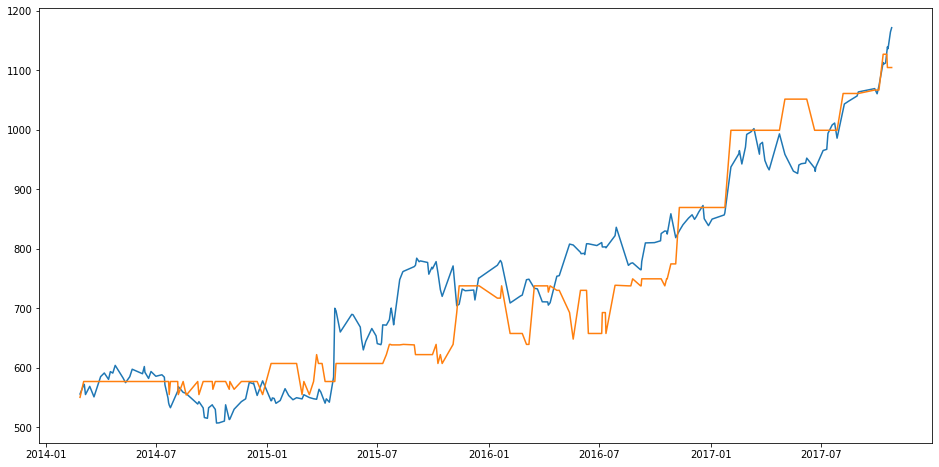

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#plots
for i in [3, 38, 154, 207]:
  Chart3 = Chart2[Chart2.Name == i]
  plt.figure(figsize=(16,8))
  plt.plot(Chart3['Y_test'], label='Close Price history')
  plt.plot(Chart3['Y_test_RF'], label='Close Price history')
# 3, 38, 154, 207 Corresponds to the 4 sample stock names: AAPL, AMZN, EBAY, GOOGL

### **Gradient Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(random_state = 100)
GBR.fit(X_train, Y_train)

In [ ]:
GBR.score(X_train, Y_train)

0.9890863897491784

In [ ]:
# Calculating Feature importance
Importance =GBR.feature_importances_
Importance_cols = df.columns[0:39]
Importance_table = pd.DataFrame(data=[Importance_cols,np.around(Importance,2)])
Importance_table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,Date,open,high,low,volume,Name,52 week high,% Over/Under 52WKH,20 Day MA,% Over Under 20DMA,50 Day MA,% Over Under 50DMA,100 Day MA,% Over Under 100DMA,200 Day MA,% Over Under 200DMA,Average Gain/Loss,Average Gains2,Av Losses2,RSI V2,S&P500_open,S&P500_high,S&P500_low,S&P500_close,S&P500_52 week high,S&P500_% Over/Under 52WKH,S&P500_20 Day MA,S&P500_% Over Under 20DMA,S&P500_50 Day MA,S&P500_% Over Under 50DMA,S&P500_100 Day MA,S&P500_% Over Under 100DMA,S&P500_200 Day MA,S&P500_% Over Under 200DMA,S&P500_Average Gain/Loss,S&P500_Average Gains2,S&P500_Av Losses2,S&P500_RSI V2,SignalVal
1,0,0.21,0.26,0,0,0.03,0,0.05,0,0.08,0,0.07,0,0.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.26


In [ ]:
Y_test_GBR = GBR.predict(X_test)
Y_test_GBR


array([249.79529241,  86.3919338 , 169.95449828, ..., 126.14542322,
       544.71236634,  35.87870462])

In [ ]:
print ("GBR accuracy is ", GBR.score(X_test,Y_test)*100)

GBR accuracy is  98.82941938737864


In [ ]:
pd.DataFrame(data=[Y_test,Y_test_GBR])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,112525,112526,112527,112528,112529,112530,112531,112532,112533,112534,112535,112536,112537,112538,112539,112540,112541,112542,112543,112544,112545,112546,112547,112548,112549,112550,112551,112552,112553,112554,112555,112556,112557,112558,112559,112560,112561,112562,112563,112564
0,282.490000,94.540000,170.780000,25.150000,95.400000,37.480000,61.650000,54.666700,32.735000,26.200000,121.090000,106.570000,78.830000,67.960000,36.800000,69.810000,65.830000,290.890000,79.960000,68.34000,40.520000,154.010000,42.940000,61.220000,71.550000,63.390000,191.550000,55.780000,103.660000,14.190000,81.220000,15.41000,47.51000,96.08000,59.590000,156.680000,82.870000,59.470000,217.960000,77.660000,...,71.170000,154.920000,125.500000,42.830000,82.260000,147.070000,130.310000,198.170000,45.000000,72.910000,46.130000,358.980000,190.360000,132.190000,191.200000,184.640000,45.130000,62.385000,114.000000,105.600000,85.590000,63.640000,67.850000,72.570000,44.300000,83.570000,44.420000,57.320000,447.900000,34.87000,47.280000,39.650000,652.480000,54.350000,137.460000,52.200000,16.260000,105.380000,514.590000,34.620000
1,249.795292,86.391934,169.954498,27.527518,99.494869,34.734349,61.944363,54.350108,32.857402,29.427872,115.582386,104.222794,85.140827,71.027318,38.230474,63.807105,66.292811,307.560474,78.100793,58.67276,62.807134,161.721965,43.841288,56.663025,74.436795,63.670522,184.960429,54.765028,93.427979,15.834337,79.349056,18.43986,42.41173,95.00703,54.524773,150.456162,77.018728,69.180331,213.018753,78.599577,...,63.129246,151.050694,119.378681,43.331036,76.270794,139.779383,131.231977,197.001679,45.614087,83.093142,42.461427,321.185361,164.282555,117.077544,186.702877,175.660422,43.348542,67.749143,112.524122,118.955324,84.167179,70.445125,66.495651,69.434366,38.626201,82.412764,43.699844,52.453919,453.987251,34.68511,64.933543,42.893281,603.268762,66.898983,103.494215,48.385861,23.205444,126.145423,544.712366,35.878705


### Graphing GBR

In [ ]:
# merging the arrays for graphing purposes
Chart1 = pd.DataFrame(data = X_test_date, columns=["Date"])
Chart2 = pd.DataFrame(data= Y_test, columns= ["Y_test"])
ChartGBR = pd.DataFrame(data= Y_test_GBR, columns= ["Y_test_GBR"])
Chart4 = pd.DataFrame(data = X_test[:,4], columns=["Name"])

Chart = pd.concat([Chart1, Chart2, ChartGBR, Chart4], axis = 1)
Chart2 = Chart.sort_values(by=['Date', "Name"], ascending= True)
Chart2["Date"] = pd.to_datetime(Chart2.Date,format='%Y-%m-%d')
Chart2.index = Chart2["Date"]

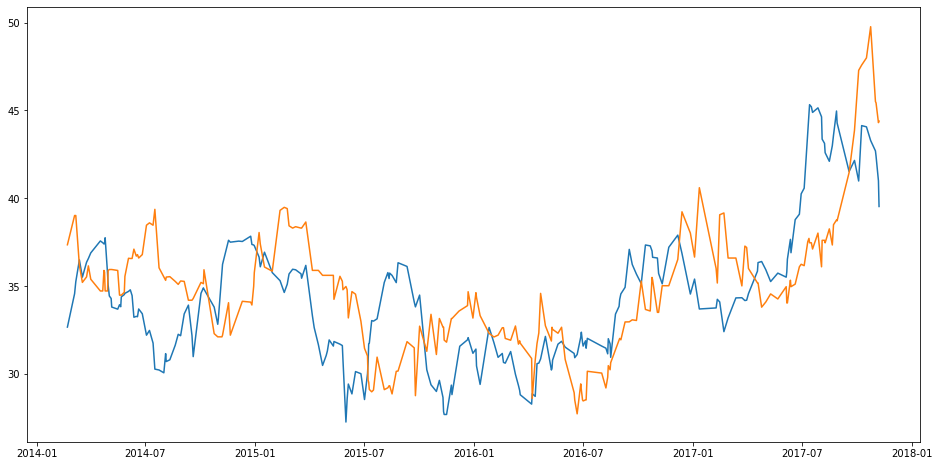

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#plots
for i in [3, 38, 154, 207]:
  Chart3 = Chart2[Chart2.Name == i]
  plt.figure(figsize=(16,8))
  plt.plot(Chart3['Y_test'], label='Close Price history')
  plt.plot(Chart3['Y_test_RF'], label='Close Price history')
# 3, 38, 154, 207 Corresponds to the 4 sample stock names: AAPL, AMZN, EBAY, GOOGL

In [ ]:
# Creating a final chart showing the Actual Y values when compared with RandomForest, AdaBoost, and GradientBoost Machine Learning algorithms
Chart_Final = pd.concat([Chart, ChartADA, ChartGBR], axis=1)
Chart_Final

,Date,Name,Y_test,Y_test_RF,Y_test_ADA,Y_test_GBR
0,2017-05-02,436,282.49,179.840654,242.575357,249.795292
1,2016-12-07,390,94.54,60.616302,83.468939,86.391934
2,2014-08-20,391,170.78,179.840654,149.550585,169.954498
3,2014-05-30,213,25.15,60.616302,69.203190,27.527518
4,2016-12-20,82,95.4,60.616302,83.468939,99.494869
...,...,...,...,...,...,...
112560,2015-02-25,337,52.2,60.616302,69.203190,48.385861
112561,2017-08-15,123,16.26,60.616302,69.203190,23.205444
112562,2017-03-15,30,105.38,164.493215,87.951414,126.145423
112563,2015-07-23,393,514.59,659.374500,545.157746,544.712366


In [ ]:
# Writing Y output to csv

# Chart_Final.to_csv(r'/content/drive/MyDrive/Colab Notebooks/ChartFinal.csv', index = False)